In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import random
import zipfile
import seaborn as sns

In [0]:
local_zip = '/content/drive/My Drive/nlp-getting-started (1).zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
train=pd.read_csv("/tmp/train.csv")
test = pd.read_csv('/tmp/test.csv')
sample_submission = pd.read_csv('/tmp/sample_submission.csv')

In [0]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [0]:
print('Train Keyword Distribution:\n\n')
print(train['keyword'].value_counts())
print('\n', '-' * 50, '\n')
print('Test Keyword Distribution:\n\n')
print(test['keyword'].value_counts())

Train Keyword Distribution:


fatalities               45
deluge                   42
armageddon               42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

 -------------------------------------------------- 

Test Keyword Distribution:


deluged                  23
rubble                   22
demolished               22
sirens                   21
annihilation             21
                         ..
fatalities                5
forest%20fire             5
radiation%20emergency     5
inundation                4
epicentre                 1
Name: keyword, Length: 221, dtype: int64


[Text(0, 0, '0: Not Disaster (4342)'), Text(0, 0, '1: Disaster (3271)')]

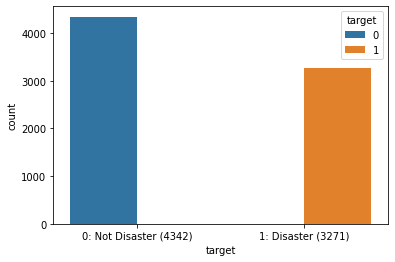

In [0]:
countplt = sns.countplot(x = 'target', data = train, hue = train['target'])
countplt.set_xticklabels(['0: Not Disaster (4342)', '1: Disaster (3271)'])

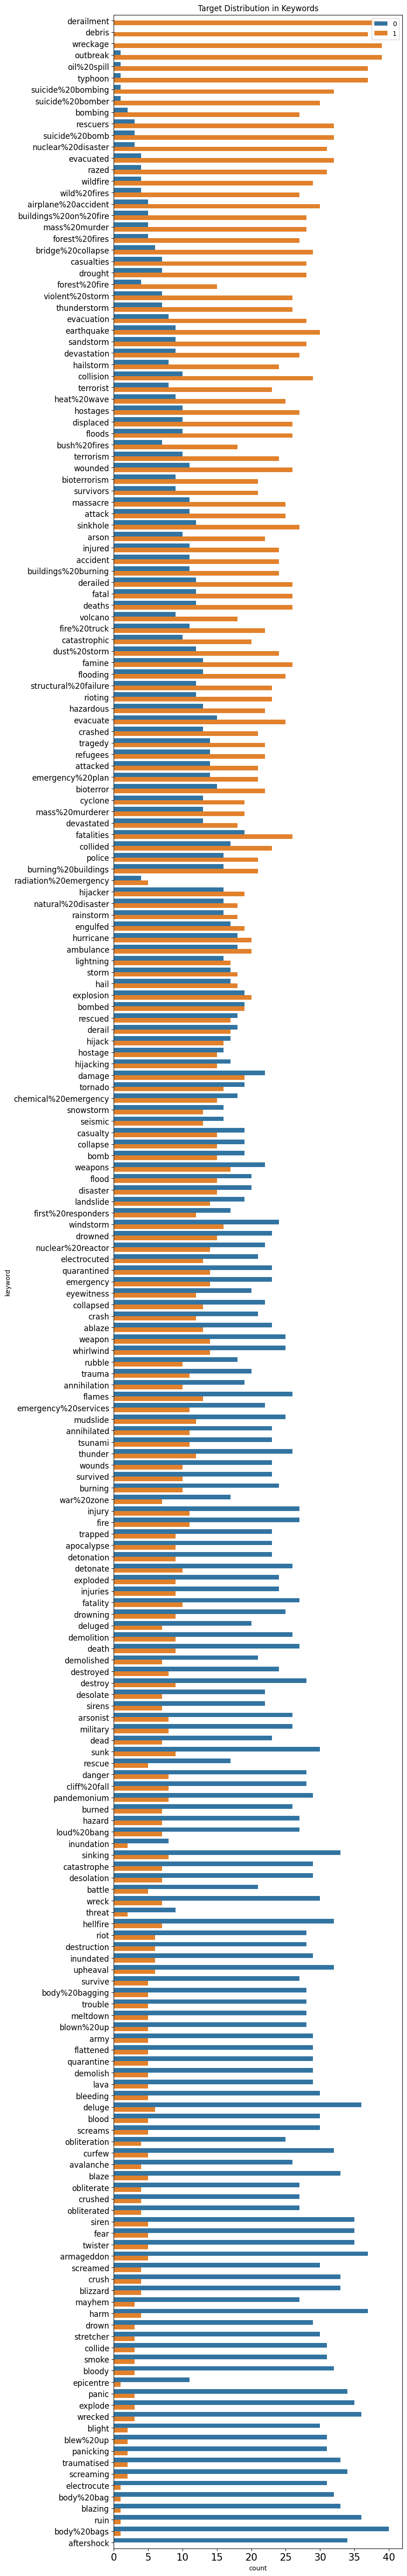

In [0]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

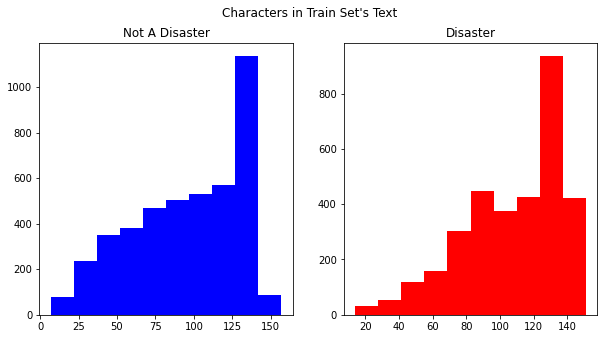

In [0]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
train_len = train[train['target'] == 0]['text'].str.len()
ax1.hist(train_len,color='blue')
ax1.set_title('Not A Disaster')
train_len = train[train['target'] == 1]['text'].str.len()
ax2.hist(train_len,color='red')
ax2.set_title('Disaster')
fig.suptitle('Characters in Train Set\'s Text')
plt.show()

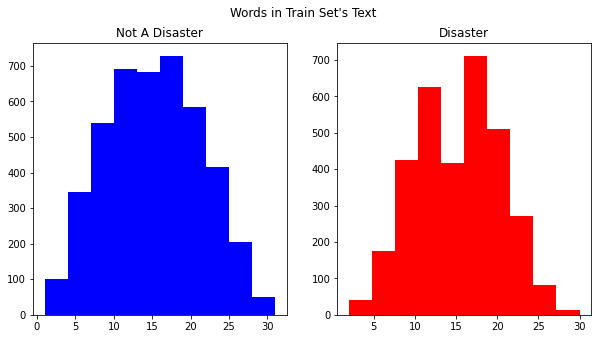

In [0]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
train_len = train[train['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('Not A Disaster')
train_len = train[train['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Disaster')
fig.suptitle('Words in Train Set\'s Text')
plt.show()


In [0]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [0]:
sentences=list(train["text"])
labels=list(train["target"])

In [0]:
print(sentences[0],labels[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 1


In [0]:
print(len(sentences),len(labels))

7613 7613


In [0]:
lens=[len(x) for x in sentences]
max_length=max(lens)
print(max_length)

157


In [0]:
embedding_dim = 100
max_length = 157
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=7613
test_portion=.1

corpus = []


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-03-17 02:05:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  62.8MB/s    in 5.3s    

2020-03-17 02:05:49 (62.8 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 157, 100)          2270100   
_________________________________________________________________
dropout (Dropout)            (None, 157, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 153, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 64)            0         
_________________________________________________________________
lstm (LSTM)                

KeyboardInterrupt: ignored

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [0]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

history = model2.fit(training_sequences, training_labels, epochs=10, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 157, 100)          2270100   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 157, 128)          84480     
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 2,400,021
Trainable params: 129,921
Non-trainable params: 2,270,100
______________________________________